### 방문자 분석

#### 라이브러리 및 설정

In [25]:
# 라이브러리
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from scipy import stats

import streamlit

In [ ]:
# 데이터 불러오기
visitor_df = pd.read_csv('./data/visitor_df.csv')

In [ ]:
# 한글 글꼴 설정
font_path = 'NanumGothic-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
mpl.rc('axes', unicode_minus=False)  # 마이너스 기호 처리
fm.fontManager.addfont(font_path)

#### 1. 방문자 수 분석

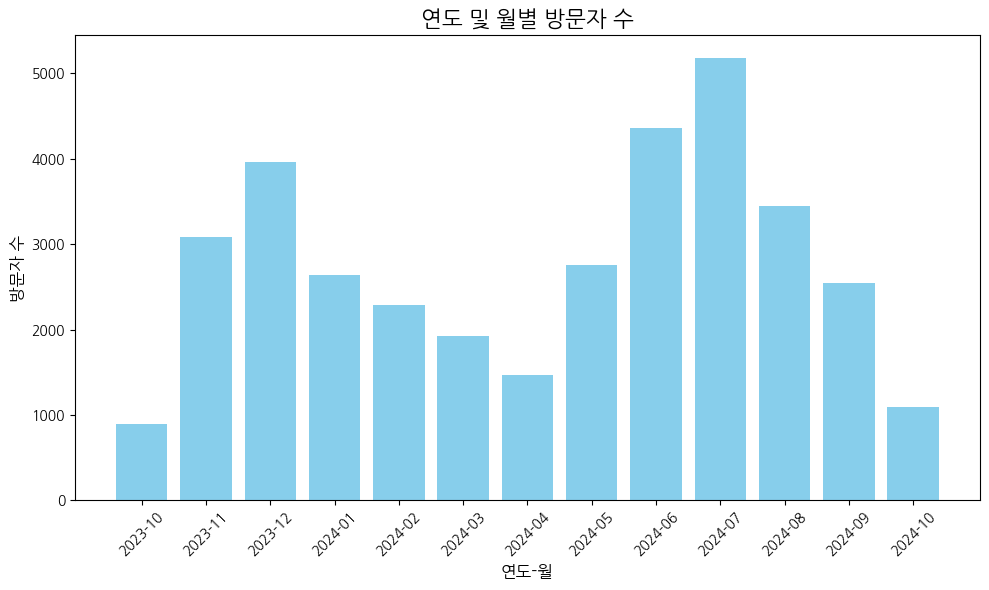

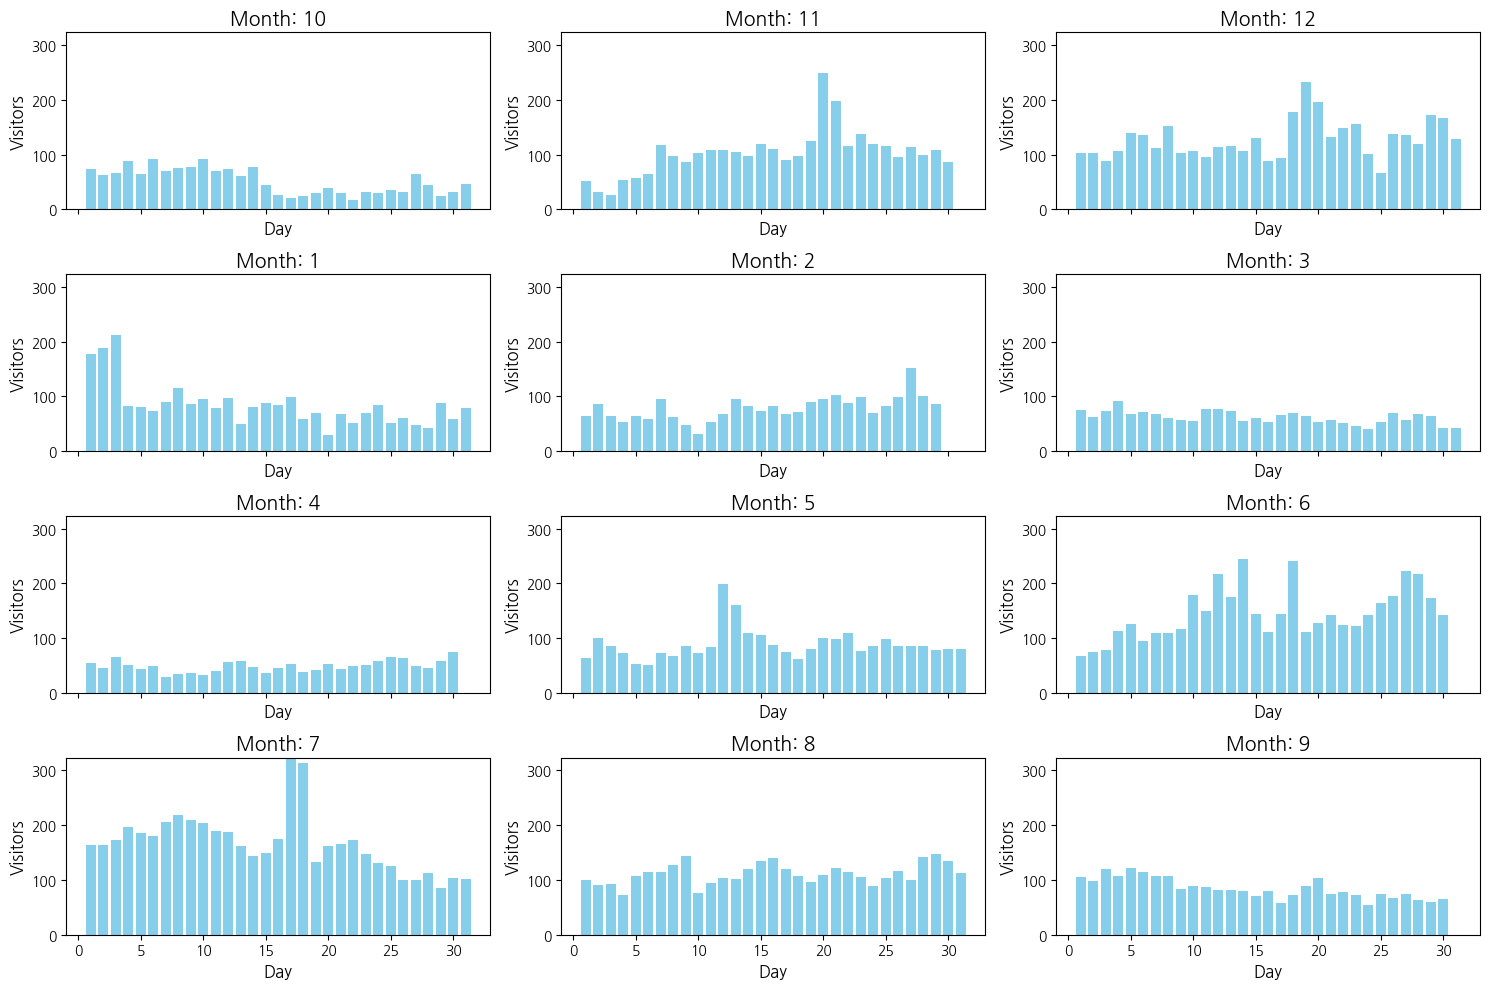

In [13]:
# 1. 날짜별 세부 정보 추가 (연도, 월, 일)
visitor_df['date'] = pd.to_datetime(visitor_df['date'])  # 날짜 형식으로 변환
visitor_df['year'] = visitor_df['date'].dt.year  # 연도 추출
visitor_df['month'] = visitor_df['date'].dt.month  # 월 추출
visitor_df['day'] = visitor_df['date'].dt.day  # 일 추출

# 2. 연-월별 방문자 피벗 테이블 생성
year_month_visitor = visitor_df.pivot_table(
    index=['year', 'month'], values='visitor', aggfunc='sum'  # 연도 및 월별로 방문자 수 집계
).reset_index()

year_month_visitor['year_month'] = (
    year_month_visitor['year'].astype(str) + '-' +  # 연도 문자열로 변환
    year_month_visitor['month'].astype(str).str.zfill(2)  # 월을 두 자리 문자열로 변환
)

# 3. 연-월별 방문자 수 그래프
plt.figure(figsize=(10, 6))
plt.bar(year_month_visitor['year_month'], year_month_visitor['visitor'], color='skyblue') 
plt.title('연도 및 월별 방문자 수', fontsize=16)
plt.xlabel('연도-월', fontsize=12)
plt.ylabel('방문자 수', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. 일별 방문자 수 그래프
daily_visitors = visitor_df.groupby(['year', 'month', 'day'])['visitor'].sum().reset_index()  # 일별 방문자 수 집계

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
max_visitors = daily_visitors['visitor'].max()

for i, month in enumerate(daily_visitors['month'].unique()):  # 각 월별 데이터 시각화
    ax = axes[i // 3, i % 3]
    month_data = daily_visitors[daily_visitors['month'] == month] 
    ax.bar(month_data['day'], month_data['visitor'], color='skyblue')
    ax.set_title(f'Month: {month}', fontsize=14)
    ax.set_ylabel('Visitors', fontsize=12)
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylim(0, max_visitors)

plt.tight_layout()
plt.show()

#### 2. 페이지 뷰 분석

전체 평균 페이지뷰 수: 5.97


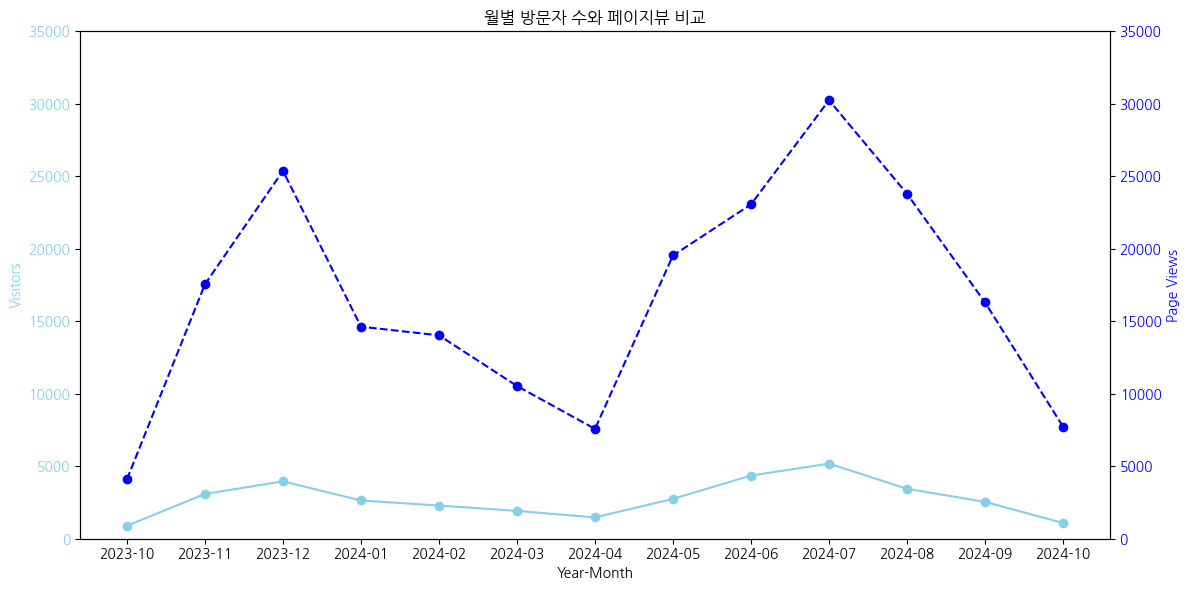

In [19]:
# 1. 평균 페이지뷰 수 계산
visitor_df['avg_pageviews_per_visitor'] = visitor_df['view'] / visitor_df['visitor']  # 평균 페이지뷰 수 계산
average_pageviews = visitor_df['avg_pageviews_per_visitor'].mean()  # 전체 평균 페이지뷰 수 계산
print(f"전체 평균 페이지뷰 수: {average_pageviews:.2f}")

# 2. 월별 방문자와 페이지뷰 비교 그래프
monthly_data = visitor_df.groupby(['year', 'month']).agg(  # 연도 및 월로 그룹화
    monthly_visitors=('visitor', 'sum'),  # 월별 방문자 수 집계
    monthly_views=('view', 'sum')  # 월별 페이지뷰 수 집계
).reset_index()

# 월별 방문자 수와 페이지뷰 수의 최대값을 기준으로 y축 범위 설정
max_value = (max(monthly_data['monthly_visitors'].max(), 
                 monthly_data['monthly_views'].max()) // 5000 + 1) * 5000

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(monthly_data['year'].astype(str) + '-' + monthly_data['month'].astype(str).str.zfill(2), 
         monthly_data['monthly_visitors'],
         color='skyblue', marker='o', label='Visitors')  # 방문자 수 그래프
ax1.set_xlabel('Year-Month')  # x축 레이블
ax1.set_ylabel('Visitors', color='skyblue')  # y축 레이블
ax1.tick_params(axis='y', labelcolor='skyblue')  # y축 색상 설정

ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.plot(monthly_data['year'].astype(str) + '-' + monthly_data['month'].astype(str).str.zfill(2), 
         monthly_data['monthly_views'],
         color='blue', marker='o', linestyle='--', label='Page Views')  # 페이지뷰 수 그래프
ax2.set_ylabel('Page Views', color='blue')  # y축 레이블
ax2.tick_params(axis='y', labelcolor='blue')  # y축 색상 설정

ax1.set_ylim(0, max_value)  # 첫 번째 y축 범위 설정
ax2.set_ylim(0, max_value)  # 두 번째 y축 범위 설정
plt.xticks(rotation=45)  # x축 레이블 회전
plt.title('월별 방문자 수와 페이지뷰 비교')  # 그래프 제목
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력


### 상관관계 분석

상관계수: 0.97, p-value: 0.0000
방문자 수와 페이지뷰 간에 유의미한 양의 상관관계가 있습니다.


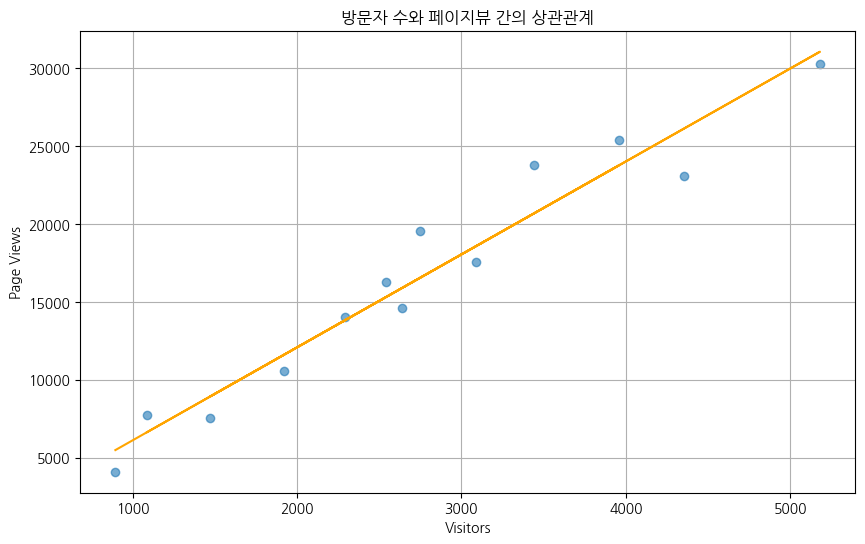

In [26]:
# 1. 정규성 검정 및 피어슨 상관계수
shapiro_visitor = stats.shapiro(monthly_data['monthly_visitors'])
shapiro_view = stats.shapiro(monthly_data['monthly_views'])
correlation, p_value = stats.pearsonr(monthly_data['monthly_visitors'], monthly_data['monthly_views'])

print(f"상관계수: {correlation:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("방문자 수와 페이지뷰 간에 유의미한 양의 상관관계가 있습니다.")
else:
    print("방문자 수와 페이지뷰 간에 유의미한 상관관계가 없습니다.")


# 2. 상관관계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(monthly_data['monthly_visitors'], monthly_data['monthly_views'], alpha=0.6)
slope, intercept = np.polyfit(monthly_data['monthly_visitors'], monthly_data['monthly_views'], 1)
plt.plot(monthly_data['monthly_visitors'], slope * monthly_data['monthly_visitors'] + intercept, color='orange')
plt.title('방문자 수와 페이지뷰 간의 상관관계')
plt.xlabel('Visitors')
plt.ylabel('Page Views')
plt.grid()
plt.show()
